## Question 1 - Inflation

In this question, I follow a Box-Jenkins method-like approach in order to develop a simple predictive model for the consumer price index US-CPI. After obtaining and transforming the data (see the next code block), there are mainly three steps:
- **Identification:** Identifying the type of ARIMA model to estimate in second step by analyzing the data and its differenced version, doing a search over candidate parameter values, and computing various statistical tools such as ACF and PACF
- **Estimation**: Estimating the model using statsmodels package and doing a very simplistic model diagnosis using summary of model fit results and residual analysis
- **Forecast**: Discussing the model's predictive performance and providing a plot of model prediction against actual inflation, showing both as a 12-month percentage change



> 1) Pull in the US CPI data from FRED using the `get_series` function (code: ‘CPIAUCSL’) and restrict the date range from 2012-01-31 to 2022-01-01. Use `pandas` to resample to month-end frequency.

In [ ]:
def getdata():
    '''
    Returns a DataFrame object df with monthly 'Date' (index) and 'CPI' column labels,
    and monthly CPI values
    '''
    fred = Fred(api_key = "2f535196e8c7bb2c1eb1705a4f9557b2")
    dseri = fred.get_series('CPIAUCSL', observation_start='2012-01-31', observation_end='2022-01-01')
    df = dseri.to_frame('CPI') # fred.get_series() returns a pandas series object, hence the conversion
    df = df.resample("M").mean() # resampling to month-end frequency where .mean() method is arbitrary
    df.index.name = "Date"
    return df

def knowdata(data):
    '''
    Returns some basic information on the structure of df, its values, and 
    returns the df
    '''
    return data.info(), data

df = getdata()
knowdata(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2012-01-31 to 2022-01-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     121 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


(None,
                 CPI
 Date               
 2012-01-31  227.842
 2012-02-29  228.329
 2012-03-31  228.807
 2012-04-30  229.187
 2012-05-31  228.713
 ...             ...
 2021-09-30  274.214
 2021-10-31  276.590
 2021-11-30  278.524
 2021-12-31  280.126
 2022-01-31  281.933
 
 [121 rows x 1 columns])

> 2) Using `sklearn`, split the dataset into appropriate "train" and "test" samples.

Here, given the low number of data points there is in our data, I choose the first 115 months for the training data and the remaining 6 months to compare the model's out-of-sample prediction. Again, a formal study would include a section dedicated to model validation via using, say, cross-validation rather than simple amd arbitrary slicing of the data.

In [ ]:
df_train = df[0:115]
df_test = df[115:len(df)]

### Identification
First, I add another column labelled 'diffCPI' to the training data sets to store daily changes and drop the NA's if any:

In [ ]:
df_train['diffCPI'] = df_train['CPI'].diff() # Creating a new column 'diffCPI' storing daily changes
df_train = df_train.dropna() 
df_train

/var/folders/14/t9yykk1s26j39htj6mj3xd640000gn/T/ipykernel_23321/560054752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['diffCPI'] = df_train['CPI'].diff() # Creating a new column 'diffCPI' storing daily changes


,CPI,diffCPI
Date,,
2012-02-29,228.329,0.487
2012-03-31,228.807,0.478
2012-04-30,229.187,0.380
2012-05-31,228.713,-0.474
2012-06-30,228.524,-0.189
...,...,...
2021-03-31,265.028,1.682
2021-04-30,266.727,1.699
2021-05-31,268.599,1.872


Now, consider the following two graphs:
- The one on left is the graph of USCPI over time.
- The one on the right is the graph of daily changes in USCPI over time.

[Text(0.5, 1.0, 'CPI (Difference of Order 1)')]

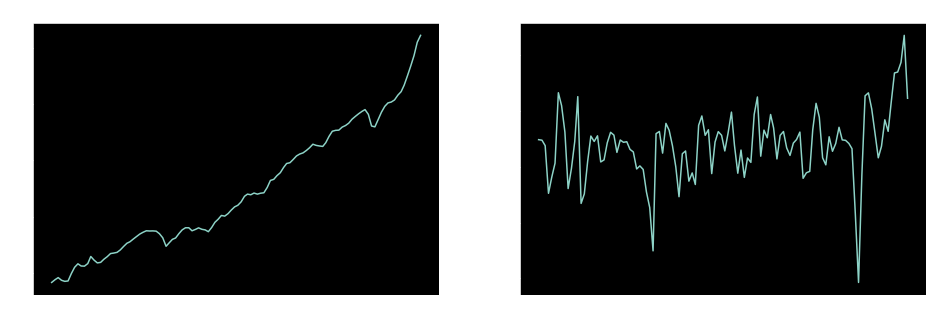

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
# Levels
axes[0].plot(df_train['CPI'])
axes[0].set(title='CPI')
# Log difference
axes[1].plot(df_train['diffCPI'])
axes[1].set(title='CPI (Difference of Order 1)')

These two graphs simply suggest the followings:
- The original series has certainly a trend factor to it and it is therefore not stationary.
- The differenced series resembles a stationary series although there seems to be some shocks to the series' dynamics. 
  - In particular there are two dropdowns in changes, one in 2015 and one in 2020, seems to be location shift in the (differenced) series distribution after the 2020 dropdown. It is always a good practice to build and estimate a structural economic model (such as sVAR) since inflation is a very structural economic variable and is certainly linked to a couple of other fundamental economic variables. Since this is a simple analysis though, I will not go into further details.

In order to confirm this insight, I also provide the following results for the augmented Dicky-Fuller test:
- The null hypothesis is that the series is non-stationary.
- For original 'CPI' values, we fail the reject the null but for the differenced 'diffCPI' values, we can safely assume stationarity given the scope and aim of this analysis.

In [ ]:
rawADF, diffADF = adfuller(df_train['CPI']), adfuller(df_train['diffCPI'])
print("p-value for CPI: ", rawADF[1], " and ", "p-value for CPI: ", diffADF[1])

p-value for CPI:  0.9988849086567781  and  p-value for CPI:  6.777120241102341e-08


The reason for analyzing the both data for stationarity is that ARIMA type models are purely statistical tools and they are only applicable under various conditions. One such condition is stationarity and it is a necessary condition for our models to be applicable to begin with. 

Probably the most important part of model identification is specifying the hypothetical data generating process. Given the differenced series 'diffCPI' exhibits properties of a stationary series, I implement an ARIMA model with one order of integration (differencing). 

Using different values for the parameters p, d, and q, there are many possible specifications for such models. These parameters roughly correspond to the effects of the fundamental time series data properties: Seasonality, trend, and noise. In this setting, while d refers to the trend factor which requires some sort of differencing, p/q refer to the degrees of lagged variables/shock-variables that are believed to affect the today's variable of interest persistently over time. 

There is a substantial literature on model selection based on parameter optimization, but for this analysis, I first implement a simple search over a simple set of possible parameter values triplets where
- p and q are allowed to be any number between 0 and 3, and 
- d is restricted to 1 since 1 order of differencing is enough to transform the series into a stationary one.

Then, I iterate over fitting the models that correspond the order triplets contained in `triplets` below. The following code block prints out all particular triplet values and the corresponding AIC/BIC values obtained by estimating each model (specification).

(For this part, I heavily benefitted from this resource I wish I found out earlier: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)

In [ ]:
p = q = range(0, 4)
d = range(1,2)
triplets = list(itertools.product(p, d, q))
warnings.filterwarnings("ignore") # to silence the warnings 
for triplet in triplets:
    try:
        model = sm.tsa.statespace.SARIMAX(df_train['CPI'], trend='c', order=triplet)
        results = model.fit(disp=False)
        print('ARIMA{} - AIC:{} - BIC:{}'.format(triplet, results.aic, results.bic))
    except:
        continue


ARIMA(0, 1, 0) - AIC:212.80885934382115 - BIC:218.26363498124584
ARIMA(0, 1, 1) - AIC:174.08678642330906 - BIC:182.2689498794461
ARIMA(0, 1, 2) - AIC:170.72672994635906 - BIC:181.63628122120843
ARIMA(0, 1, 3) - AIC:172.67195830192787 - BIC:186.30889739548957
ARIMA(1, 1, 0) - AIC:174.86000768677485 - BIC:183.04217114291188
ARIMA(1, 1, 1) - AIC:171.61190713802642 - BIC:182.5214584128758
ARIMA(1, 1, 2) - AIC:172.69537493960422 - BIC:186.33231403316591
ARIMA(1, 1, 3) - AIC:174.72188624211017 - BIC:191.0862131543842
ARIMA(2, 1, 0) - AIC:170.62421996775845 - BIC:181.53377124260783
ARIMA(2, 1, 1) - AIC:172.6166478040798 - BIC:186.2535868976415
ARIMA(2, 1, 2) - AIC:174.03054219989107 - BIC:190.3948691121651
ARIMA(2, 1, 3) - AIC:173.79769919909998 - BIC:192.88941393008636
ARIMA(3, 1, 0) - AIC:172.61101889740112 - BIC:186.24795799096282
ARIMA(3, 1, 1) - AIC:173.3697976359721 - BIC:189.73412454824614
ARIMA(3, 1, 2) - AIC:174.65808597980435 - BIC:193.74980071079074
ARIMA(3, 1, 3) - AIC:175.8142808

Both AIC and BIC are metrics that favor simpler models where BIC does even more so, and the lower values correspond to better model fits. From this perspective, considering both AIC and BIC results together suggests that ARIMA(0,1,2), ARIMA(1,1,1), or ARIMA(2,1,0) could work fine. It is obvious that there is no incremental benefit from going further.


Second, I also exploring the implications of ACF and PACF for the 'diffCPI' data, shown in the next code block: 
- ACF cuts off in its values after the first lag, tailing off in a some kind of symmetric pattern around zero.
- PACF cuts off after first/second lag as well with similar behavior to ACF lag values.
- These patterns suggest that most probably there is no benefit to the model fit from adding the third or more lag terms, so the models listed above would be appropriate for a simple analysis.
  - A more formal model should take the symmetric pattern of ACF and PACF lag values into consideration during the identification of a model as there are likely to be seasonal effects in a consumption index series.

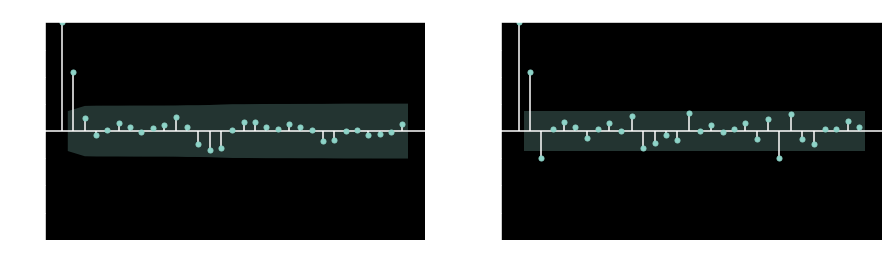

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(df_train['diffCPI'], lags=30, zero='False', ax=axes[0])
fig = plot_pacf(df_train['diffCPI'], lags=30, zero='False',  ax=axes[1])

### Estimation & Model Diagnosis

> 3) Using `statsmodels`, fit an ARIMA-type model to the training data that can be used to forecast inflation. Provide justification for the selection of parameters used in your ARIMA model. Be sure to show a summary of the results from the model fit. 

Based on a comparison between the three models, ARIMA(2,1,0)/ARIMA(0,1,2)/ARIMA(1,1,1), rest of the analysis is based upon the ARIMA(1,1,1) model since they are statistically indistinguishable from each other. The following code block fits this model and prints its summary results:

In [ ]:
model = sm.tsa.statespace.SARIMAX(df_train['CPI'], trend='c', order=(1,1,1))
results = model.fit(disp=False)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  114
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -81.806
Date:                Wed, 16 Feb 2022   AIC                            171.612
Time:                        09:05:32   BIC                            182.521
Sample:                    02-29-2012   HQIC                           176.039
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2645      0.084      3.161      0.002       0.101       0.429
ar.L1          0.3231      0.150      2.161      0.031       0.030       0.616
ma.L1          0.3391      0.181      1.878      0.0

Given that I already provided the justification behind the particular model parameters I chose, I briefly comment on the model fit statistics:
- First, the MA parameter is statistically significant at only %10 level while the AR parameter is so at %5 level.
- A quick look into the statistics for the residuals, it is good that `Prob(Q)` is quite high and hence no implied correlation between residuals.
  
Lastly, I also produce some diagnostic tools below for the residuals fitted model implies. Accordingly, I can conclude:
- In accordance with the model summary results above, residuals do not follow a standard normal distribution: They rather follow a narrower normal distribution and this implies the analysis can improved upon if one considers a broader set of model specifications.
- Our residuals seem to move around the zero line, correlogram confirms white-noise nature of residuals, and given everything else so far, it is safe to conclude that our model is not ill-conditioned although it fits the data poorly in some dimensions.

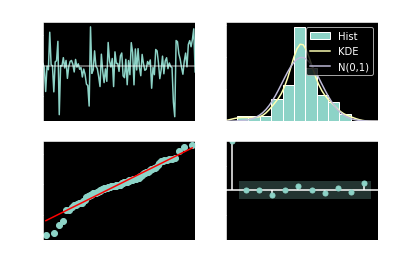

In [ ]:
results.plot_diagnostics()
plt.show()

## Forecasting

> 4) Plot your full sample prediction against actual inflation, showing both as a 12-month percentage change. 

First, the next code block outputs the original 'CPI' series and model's prediction using this data:

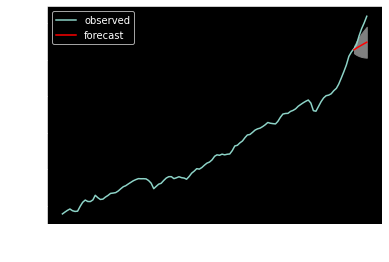

In [ ]:
forecast = results.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower CPI']
upper_limits = confidence_intervals.loc[:,'upper CPI']
#plot setting
plt.plot(df['CPI'], label='observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='grey')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

Now, some brief comments on the prediction performance of the model using the undifferenced 'CPI' data: 
- The prediction period overlaps with the recent inflationary environment so this might render the model pretty useless for prediction, unless the recent structural change in the policy environment is somehow handled during the model selection. An ARIMAX kind of model to control for some other economically related variables or a structural model could make a difference in this sense.
- Although the prediction performance is quite low partly due to the recent persistent increase, the predictions seem to reflect the dominant pattern exhibited by pre-2020 data.

Next, and lastly for this question, I plot the predicted vs actual CPI data in terms of inflation, defined as the 12-month percentage change in the original series. In the end, the model does a poor job of predicting the actual inflation.

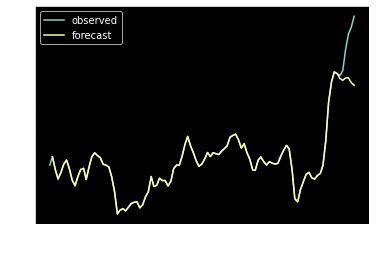

In [ ]:
# Appending the forecasted values to the end of df_train only for the purpose of showing forecast in terms of inflation
df_new = pd.concat([df_train['CPI'], forecast.predicted_mean]) 
df_new = df_new.pct_change(12) * 100
df_inf = df.pct_change(12) * 100
plt.plot(df_inf, label='observed')
plt.plot(df_new, label='forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()
